In [1]:
import pandas as pd
import numpy as np

In [13]:
df_original = pd.read_csv('C:\\Users\\Liu Shi Peng\\Downloads\\lalonde.csv')

In [15]:
df_original.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899


In [17]:
df_original.describe()

,treat,age,educ,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [23]:
df = pd.get_dummies(df_original, columns = ['race'], drop_first = True)

In [25]:
df.head()

,rownames,treat,age,educ,married,nodegree,re74,re75,re78,race_hispan,race_white
0,NSW1,1,37,11,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,0,1,0.0,0.0,289.7899,False,False


In [37]:
print(df[df['treat'] ==1]['re78'].mean())
print(df[df['treat'] ==0]['re78'].mean())

6349.143530270271
6984.169742307692


## linear regression

In [44]:
features = [x for x in df.columns if x not in ['rownames', 're78']]
features

['treat',
 'age',
 'educ',
 'married',
 'nodegree',
 're74',
 're75',
 'race_hispan',
 'race_white']

In [48]:
from sklearn.linear_model import LinearRegression

features = [x for x in df.columns if x not in ['rownames', 're78']]
X = df[features]
y = df['re78']

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [50]:
lr.coef_

array([1.54824380e+03, 1.29776337e+01, 4.03941231e+02, 4.06620845e+02,
       2.59817368e+02, 2.96377443e-01, 2.31525876e-01, 1.73954095e+03,
       1.24064408e+03])

In [52]:
lr.intercept_

-1174.1295623271963

### Propensity Score Matching

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

features = [x for x in df.columns if x not in ['rownames','treat', 're78']]
X = df[features]
y = df['treat']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

log_r = LogisticRegression()
log_r.fit(X_scaled, y) 

LogisticRegression()

In [81]:
log_r.predict_proba(X_scaled)

array([[0.44758221, 0.55241779],
       [0.7454561 , 0.2545439 ],
       [0.34721899, 0.65278101],
       ...,
       [0.8661163 , 0.1338837 ],
       [0.55220333, 0.44779667],
       [0.88945462, 0.11054538]])

In [83]:
from sklearn.metrics import accuracy_score

y_pred = log_r.predict(X_scaled)
accuracy = accuracy_score(y_pred, y)

0.8273615635179153

In [97]:
predict_outcome = pd.DataFrame({'y_act':y, 'y_pred':y_pred, 'prob':log_r.predict_proba(X_scaled)[:, 1]})
predict_outcome.head(15)

,y_act,y_pred,prob
0,1,1,0.552418
1,1,0,0.254544
2,1,1,0.652781
3,1,1,0.719107
4,1,1,0.687916
5,1,1,0.684893
6,1,1,0.641428
7,1,1,0.726224
8,1,1,0.696525
9,1,0,0.048942


#### finding common support

In [102]:
import matplotlib.pyplot as plt

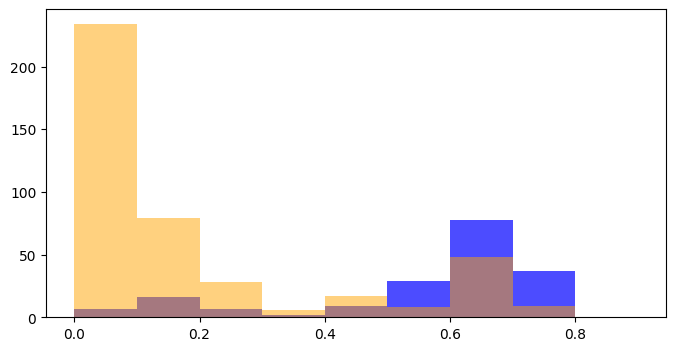

In [130]:
plt.figure(figsize = (8,4))
bins = np.arange(0,1, 0.1)
plt.hist(predict_outcome[predict_outcome['y_act'] == 1]['prob'], bins = bins, alpha = 0.7, color = 'blue')
plt.hist(predict_outcome[predict_outcome['y_act'] == 0]['prob'], bins = bins, alpha = 0.5, color = 'orange')
plt.show()

#### matching

In [133]:
from sklearn.neighbors import NearestNeighbors

In [167]:
predict_outcome['id'] = range(len(predict_outcome))
predict_outcome.head()

,y_act,y_pred,prob,id
0,1,1,0.552418,0
1,1,0,0.254544,1
2,1,1,0.652781,2
3,1,1,0.719107,3
4,1,1,0.687916,4


In [169]:
treat = predict_outcome[predict_outcome['y_act'] == 1]
control = predict_outcome[predict_outcome['y_act'] == 0]

nbrs = NearestNeighbors(n_neighbors = 1).fit(control[['prob']])
distances, indices = nbrs.kneighbors(treat[['prob']])

In [187]:
matched_control_indices = indices.flatten()
new_control = control.iloc[matched_control_indices]
matched_data = pd.concat([treat, new_control])
# matched_data

In [193]:
df.iloc[matched_control_indices]['re78'].mean()

7242.873307729729

In [199]:
df.iloc[treat['id']]['re78'].mean()

6349.143530270271

In [201]:
matched_data

,y_act,y_pred,prob,id
0,1,1,0.552418,0
1,1,0,0.254544,1
2,1,1,0.652781,2
3,1,1,0.719107,3
4,1,1,0.687916,4
...,...,...,...,...
484,0,0,0.335824,484
334,0,0,0.235865,334
190,0,0,0.436153,190
282,0,0,0.428935,282


In [205]:
df_psm = df.iloc[matched_data['id']]
df_psm.head()

,rownames,treat,age,educ,married,nodegree,re74,re75,re78,race_hispan,race_white
0,NSW1,1,37,11,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,0,1,0.0,0.0,289.7899,False,False


#### desnity plot before vs after matching

##### before

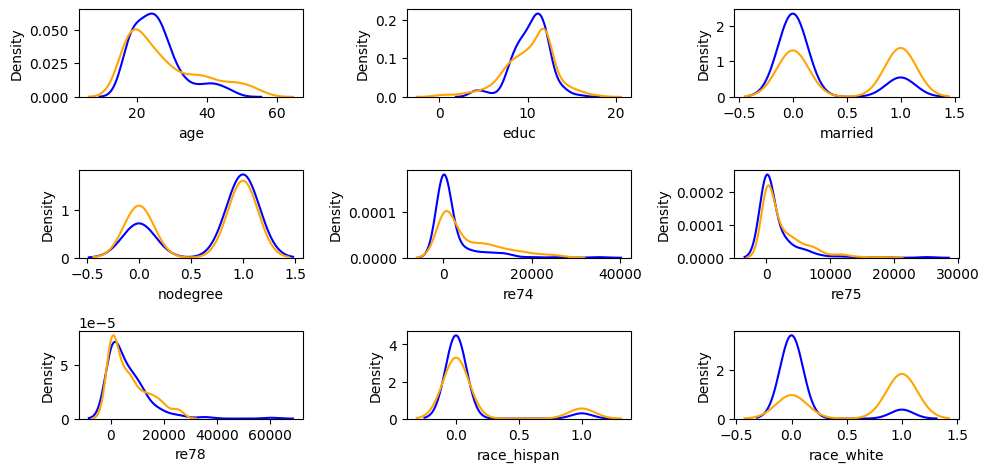

In [232]:
import seaborn as sns
plt.figure(figsize = (10,6))
for i, col in enumerate(['age', 'educ', 'married', 'nodegree', 're74', 're75', 're78', 'race_hispan', 'race_white'], 1):
    plt.subplot(4,3,i)
    sns.kdeplot(df[df['treat'] == 1][col], label = f'plot - {col}', color = 'blue')
    sns.kdeplot(df[df['treat'] == 0][col], label = f'plot - {col}', color = 'orange')
    plt.tight_layout()
    plt.plot()

##### after

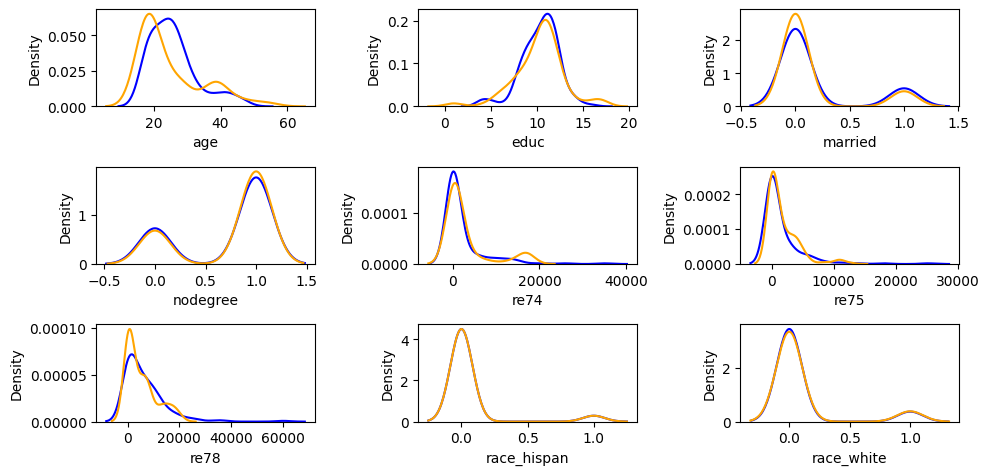

In [230]:
import seaborn as sns
plt.figure(figsize = (10,6))
for i, col in enumerate(['age', 'educ', 'married', 'nodegree', 're74', 're75', 're78', 'race_hispan', 'race_white'], 1):
    plt.subplot(4,3,i)
    sns.kdeplot(df_psm[df_psm['treat'] == 1][col], label = f'plot - {col}', color = 'blue')
    sns.kdeplot(df_psm[df_psm['treat'] == 0][col], label = f'plot - {col}', color = 'orange')
    plt.tight_layout()
    plt.plot()

### Linear Regresssion + PSM

In [235]:
from sklearn.linear_model import LinearRegression

features = [x for x in df_psm.columns if x not in ['rownames', 're78']]
X = df_psm[features]
y = df_psm['re78']

lr = LinearRegression()
lr.fit(X, y)
lr.coef_

array([ 1.27742119e+03, -7.03225060e+01,  4.28523275e+02,  1.21316524e+03,
       -5.94314736e+02, -5.12893690e-03,  3.51380449e-01,  1.21149107e+03,
        1.11623864e+03])